In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import pickle
%matplotlib inline

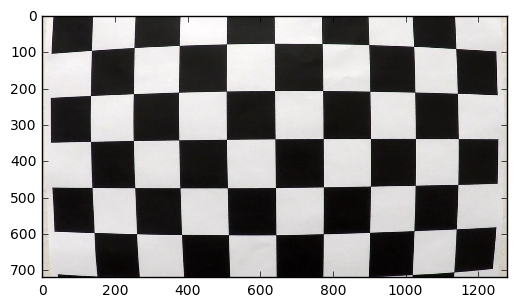

In [2]:
img = mpimg.imread('camera_cal/calibration1.jpg')
plt.imshow(img)

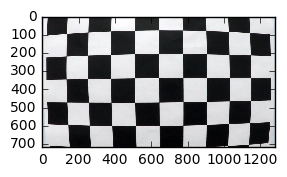

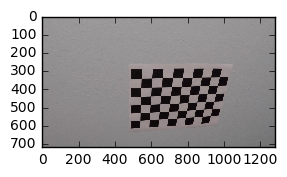

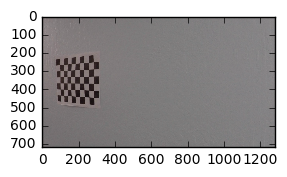

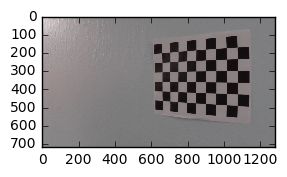

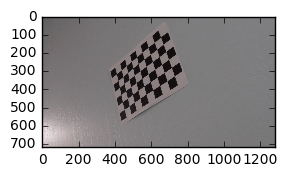

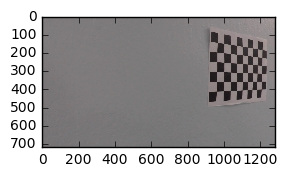

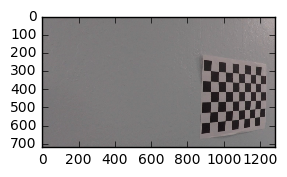

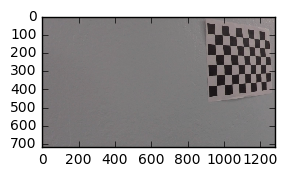

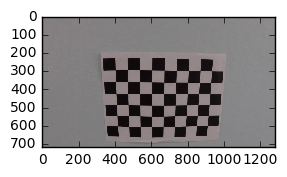

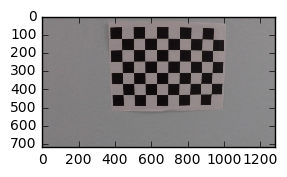

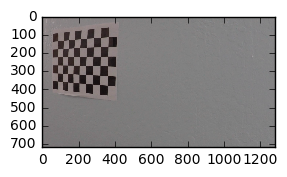

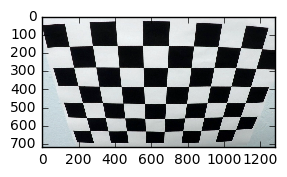

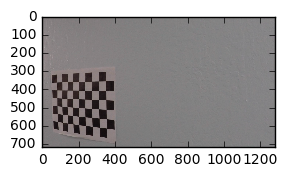

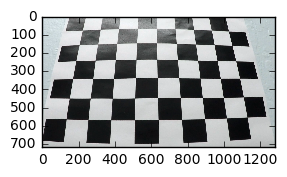

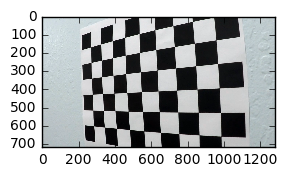

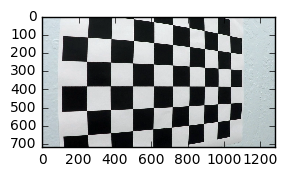

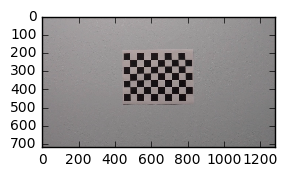

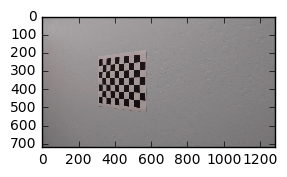

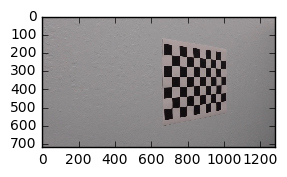

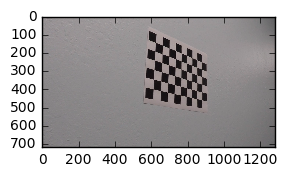

In [85]:
cal_img = []
for filename in os.listdir("camera_cal/"):
    img = cv2.imread(os.path.join('camera_cal',filename))
    cal_img.append(img)

for ima in cal_img:
    plt.figure(figsize=(3, 3))
    plt.imshow(ima)

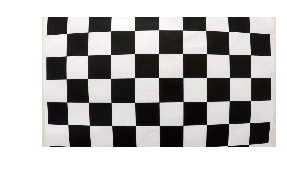

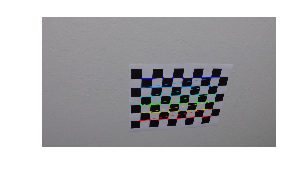

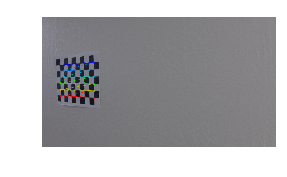

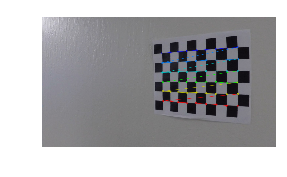

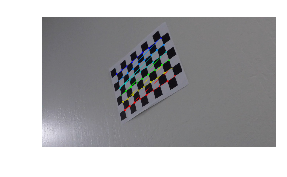

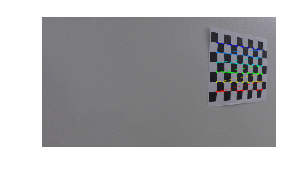

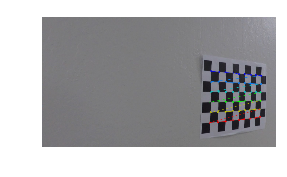

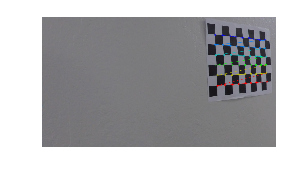

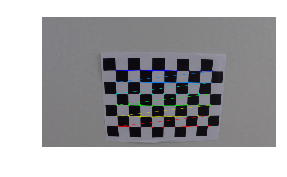

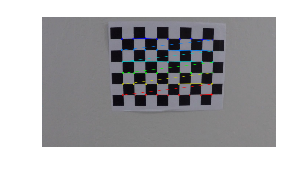

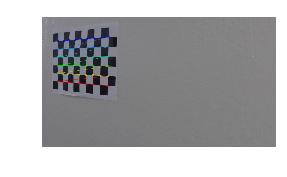

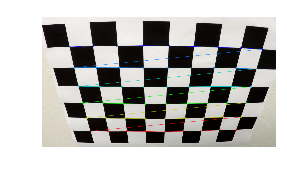

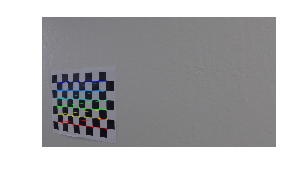

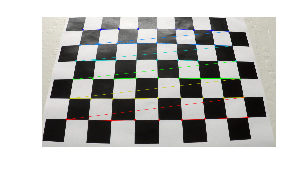

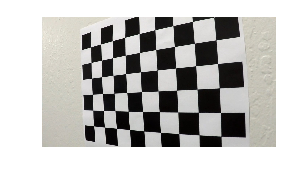

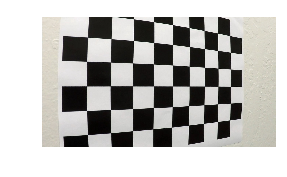

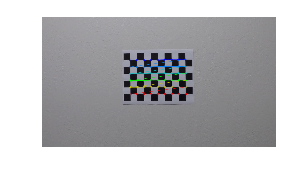

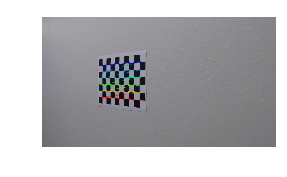

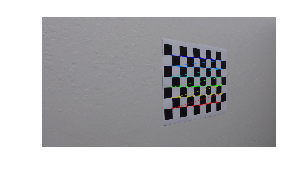

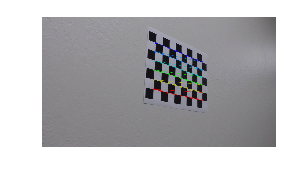

In [4]:
nx = 9
ny = 6

objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

objpoints = []
imgpoints = []

for img in cal_img:
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        
        
for img in cal_img:
    plt.figure(figsize=(3, 3))
    plt.imshow(img)
    plt.axis('off')

In [5]:
img = cal_img[5]
img_size = (img.shape[1], img.shape[0])
img_size

(1280, 720)

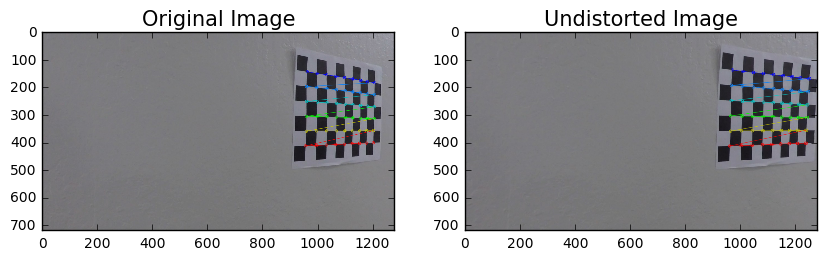

In [6]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

data = [mtx, dist]

undst = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize = 15)
ax2.imshow(undst)
ax2.set_title('Undistorted Image', fontsize = 15)

In [7]:
data

[array([[  1.15396093e+03,   0.00000000e+00,   6.69705359e+02],
        [  0.00000000e+00,   1.14802495e+03,   3.85656232e+02],
        [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]]),
 array([[ -2.41017968e-01,  -5.30720497e-02,  -1.15810318e-03,
          -1.28318543e-04,   2.67124302e-02]])]

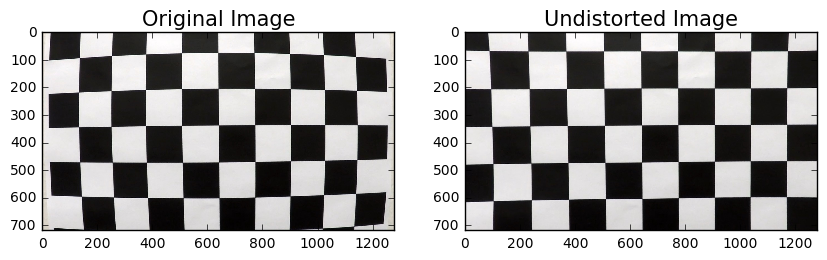

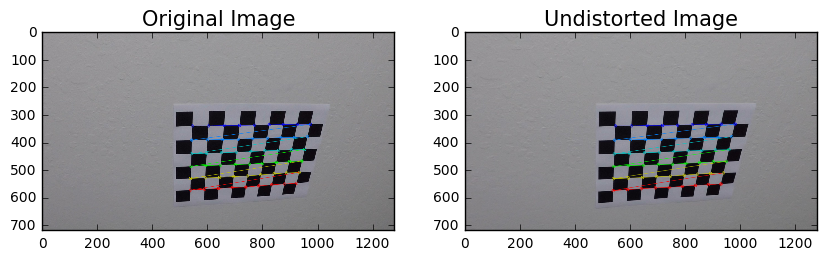

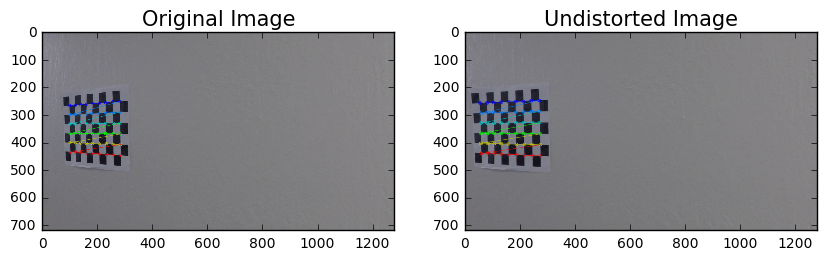

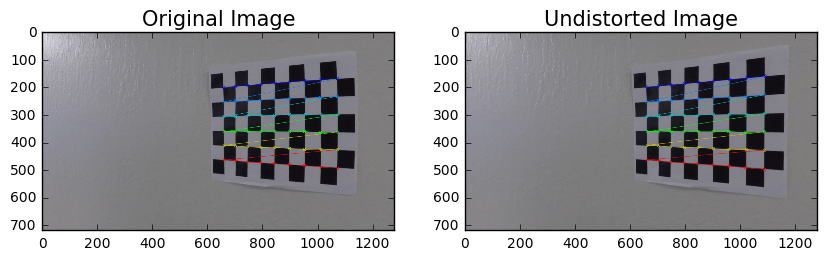

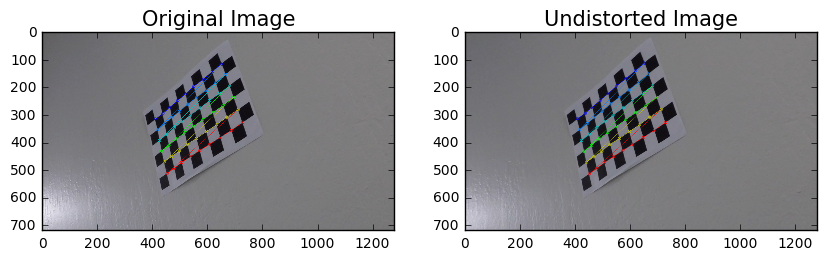

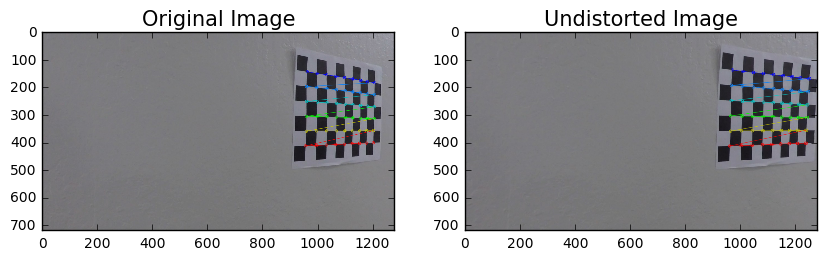

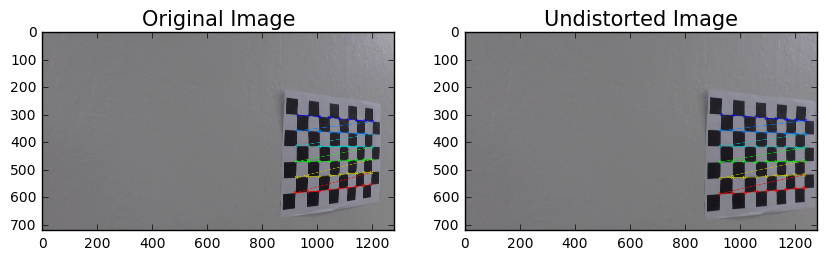

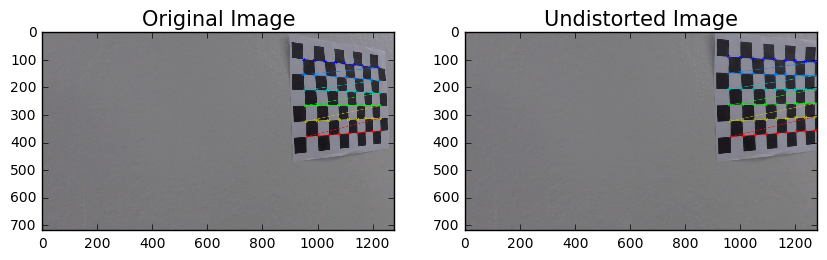

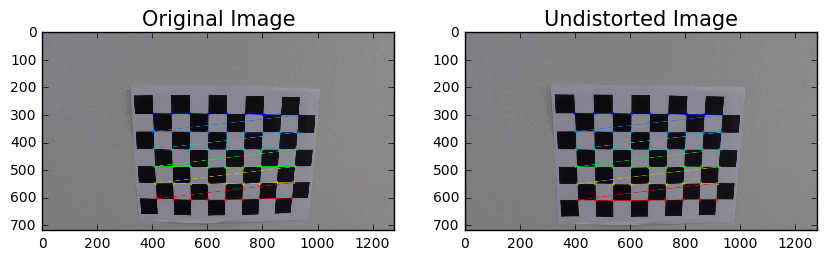

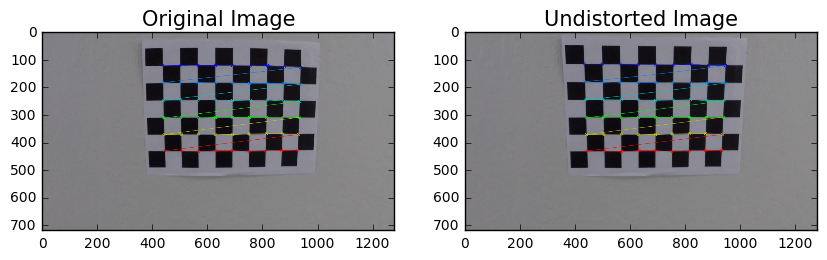

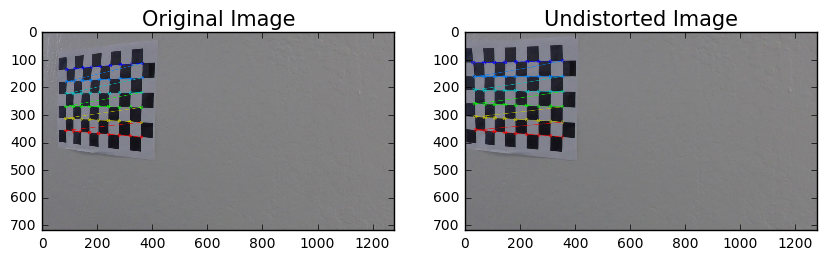

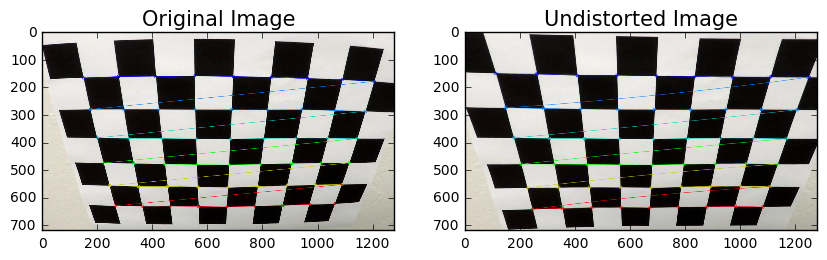

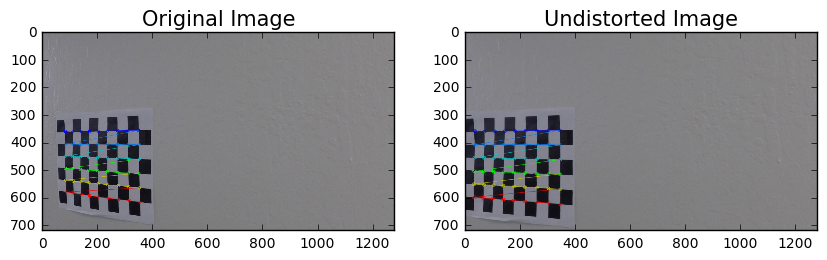

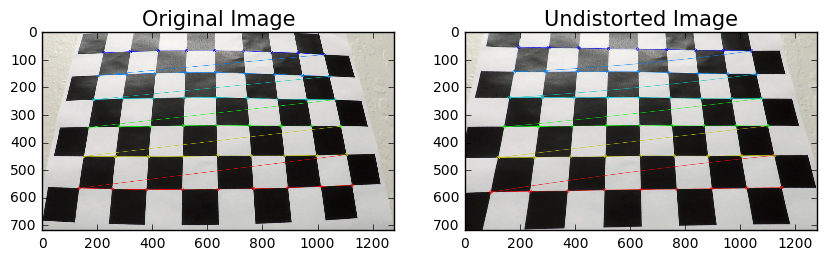

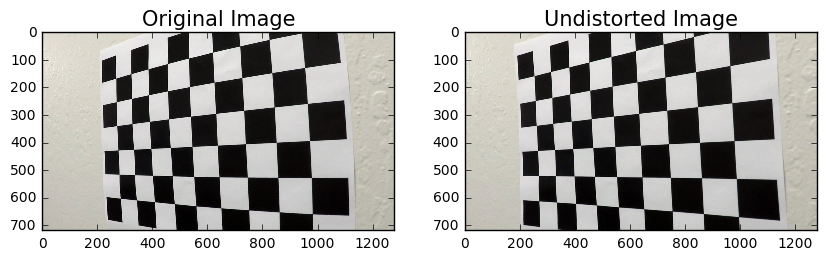

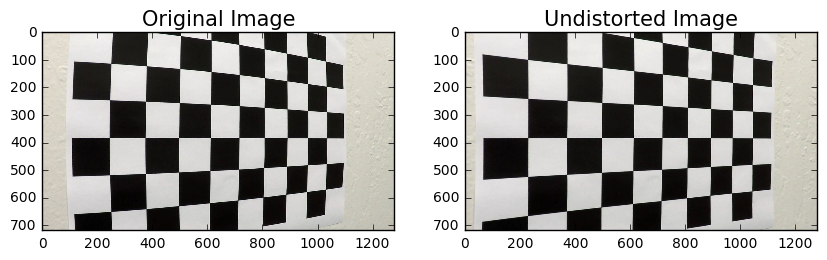

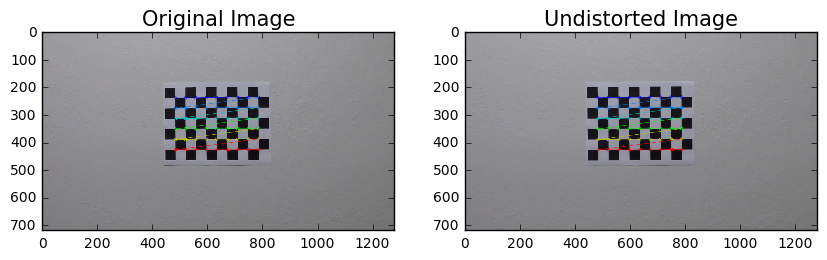

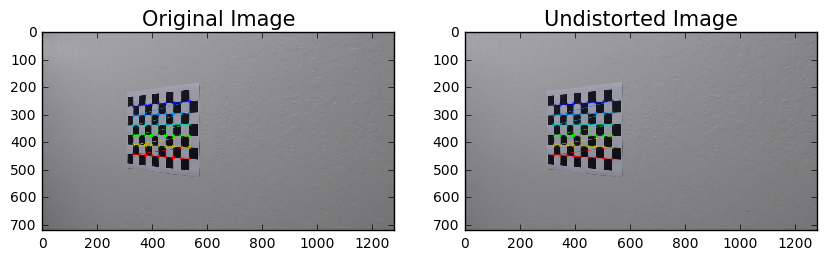

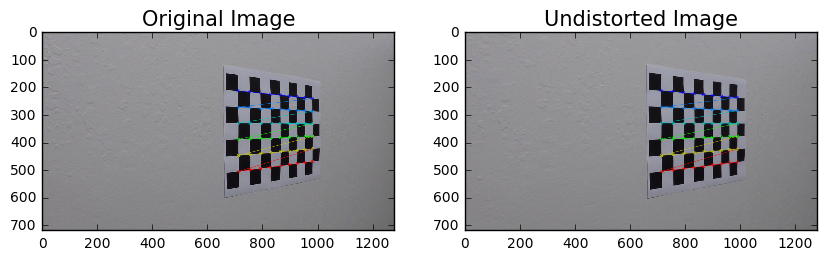

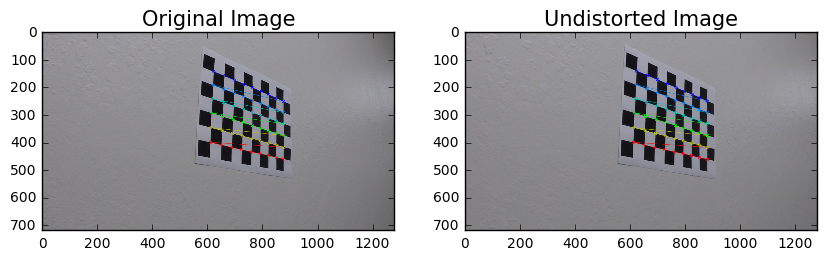

In [8]:
for img in cal_img:
    undst = cv2.undistort(img, mtx, dist, None, mtx)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize = 15)
    ax2.imshow(undst)
    ax2.set_title('Undistorted Image', fontsize = 15)

In [37]:
ksize = 3

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def abs_sobel_thresh(img, orient = 'x', sobel_kernel=ksize, thresh=(30, 50)):
    
    if orient == 'x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    if orient == 'y':
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel >= thresh[1])] = 1
    return grad_binary

def mag_thresh(img, sobel_kernel=ksize, thresh=(0, 255)):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    mag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(mag)/255
    scaled_mag = np.uint8(mag/scale_factor)
    mag_binary = np.zeros_like(scaled_mag)
    mag_binary[(scaled_mag >= thresh[0]) & (scaled_mag <= thresh[1])] = 1
    return mag_binary

def dir_thresh(img, sobel_kernel=ksize, thresh=(0, np.pi/2)):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    dir_grad = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(dir_grad)
    dir_binary[(dir_grad >= thresh[0]) & (dir_grad <= thresh[1])] = 1
    return dir_binary

def gray_f(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return gray

def hsv_select(img, thresh=(0, 255)):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    s_channel = hsv[:,:,1]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

def undist_f(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

def transform(img):
    img_size = (img.shape[1], img.shape[0])
    undst = cv2.undistort(img, mtx, dist, None, mtx)
    
    src = np.float32(
        [[(img_size[0] * 3/16) - 20, img_size[1]],
         [(img_size[0] - 60), img_size[1]],
         [(img_size[0]/2 + 110), img_size[1] * 2/3],
         [(img_size[0]/3 + 125), img_size[1] * 2/3]])

    dst = np.float32(
        [[(img_size[0] * 3/16), img_size[1]],
         [(img_size[0] * 13/16), img_size[1]],
         [(img_size[0] * 13/16), img_size[1]/2 - 60],
         [(img_size[0] * 3/16), img_size[1]/2 - 60]])

    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    Minv = cv2.getPerspectiveTransform(dst, src)

    return warped, Minv, M


In [38]:
images = []
for filename in os.listdir("test_images/"):
    img = cv2.imread(os.path.join('test_images',filename))
    images.append(img)

In [39]:
os.listdir("test_images/")

['solidWhiteRight.jpg',
 'solidYellowLeft.jpg',
 'test1.jpg',
 'test2.jpg',
 'test3.jpg',
 'test4.jpg',
 'test5.jpg',
 'test6.jpg']

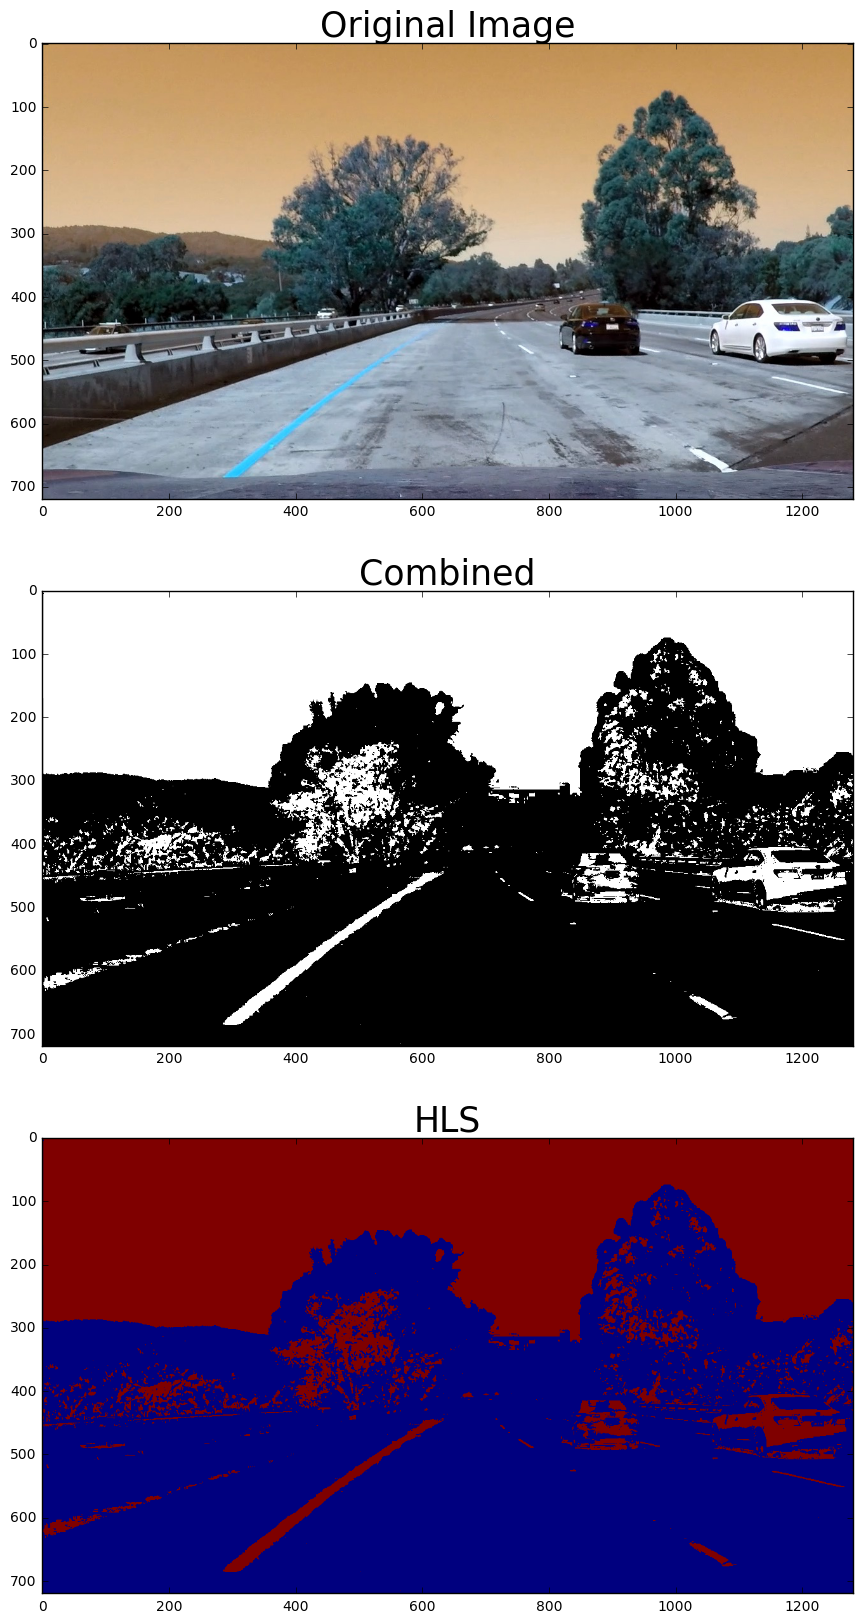

In [40]:
img = images[2]
imshape = img.shape
img_size = (img.shape[1], img.shape[0])
vertices = np.array([[(160,imshape[0]),(imshape[1]/2-60, imshape[0]/2+90),
                  (imshape[1]/2+100, imshape[0]/2+90), (imshape[1]-20,imshape[0])]], dtype=np.int32)
undist = undist_f(img)
gray = gray_f(undist)
gauss_blur = gaussian_blur(gray, 3)
hsv = hsv_select(undist, thresh=(100, 255))
hls_binary = hls_select(img, thresh=(90,255))
reg_int = region_of_interest(gauss_blur, vertices)
gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(30, 150))
gradx = region_of_interest(gradx, vertices)
grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(140, 255))
grady = region_of_interest(grady, vertices)
mag_binary = mag_thresh(gray, sobel_kernel=ksize, thresh=(30, 120))
mag_binary = region_of_interest(mag_binary, vertices)
dir_binary = dir_thresh(gray, sobel_kernel=ksize, thresh=(0.7, 1.8))
dir_binary = region_of_interest(dir_binary, vertices)
combined = np.zeros_like(hls_binary)
combined[((gradx == 1) & (grady == 1) | (mag_binary == 1) & (dir_binary == 1) | (hls_binary == 1))] = 1
#plt.figure(figsize=(3, 3))
#plt.imshow(combined, cmap = 'gray')
#plt.imshow(hls_binary, cmap ='gray')
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 20))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize = 25)
ax2.imshow(combined, cmap ='gray')
ax2.set_title('Combined', fontsize = 25)
ax3.imshow(hls_binary)
ax3.set_title('HLS', fontsize = 25)

In [41]:
img_size

(1280, 720)

In [42]:
#src=np.float32([[(160,img_size[1]),(img_size[0]/2-60, img_size[1]/2+90),
                  #(img_size[0]/2+100, img_size[1]/2+90), (img_size[0]-20,img_size[1])]], dtype=np.int32)
#dst=np.float32([[(240,img_size[1]),(240, 0),(img_size[0]-130, 0), (img_size[0]-130,img_size[1])]])

# src = np.float32(
#         [[(img_size[0] * 3/16) - 20, img_size[1]],
#          [(img_size[0] - 60), img_size[1]],
#          [(img_size[0]/2 + 110), img_size[1] * 2/3],
#          [(img_size[0]/3 + 125), img_size[1] * 2/3]])

# dst = np.float32(
#         [[(img_size[0] * 3/16), img_size[1]],
#          [(img_size[0] * 13/16), img_size[1]],
#          [(img_size[0] * 13/16), img_size[1]/2 - 60],
#          [(img_size[0] * 3/16), img_size[1]/2 - 60]])

#src = np.float32([(580, 300), (820, 540), (160, 540), (320, 300)])
#dst = np.float32([(650, 200), (750, 540), (250, -540), (200, 200)])

#src = np.float32([[570, 350], [800, 600], [180, 600], [420, 350]])
#dst = np.float32([[310, 120], [310, 719], [1000, 719], [1000, 120]])

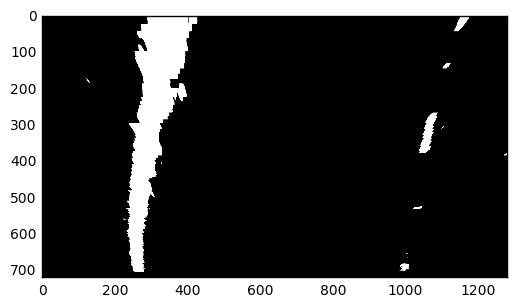

In [43]:
warper, Minv, M = transform(combined)
plt.imshow(warper, cmap='gray')

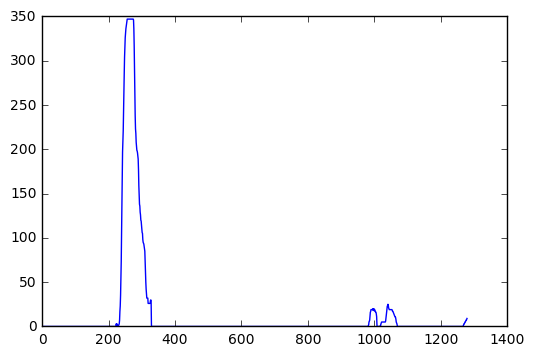

In [44]:
histogram = np.sum(warper[warper.shape[0]/2:,:], axis=0)
plt.plot(histogram)

(720, 0)

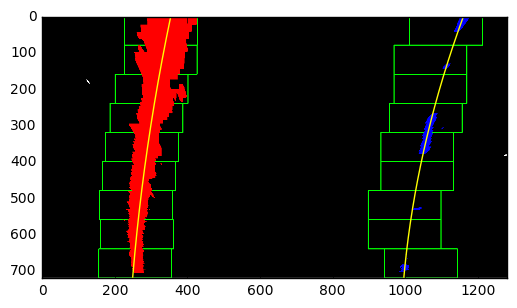

In [45]:
out_img = np.dstack((warper, warper, warper))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(warper.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = warper.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = warper.shape[0] - (window+1)*window_height
    win_y_high = warper.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)


ploty = np.linspace(0, warper.shape[0]-1, warper.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

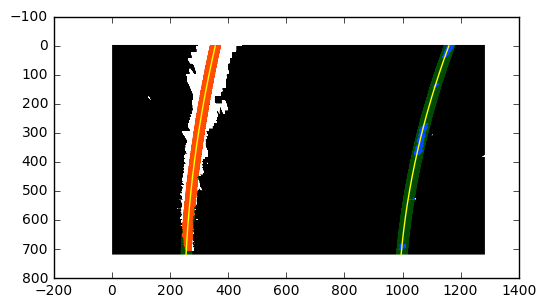

In [80]:
nonzero = warper.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 20
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, warper.shape[0]-1, warper.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img = np.dstack((warper, warper, warper))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))

lane_line = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(lane_line)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
# plt.xlim(0, 1280)
# plt.ylim(720, 0)

In [26]:
Minv = cv2.getPerspectiveTransform(dst, src)

In [81]:
unwarp_lane = cv2.warpPerspective(lane_line, Minv, img_size, flags=cv2.INTER_LINEAR)

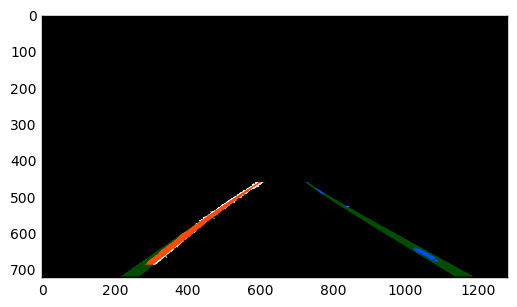

In [82]:
plt.imshow(unwarp_lane)

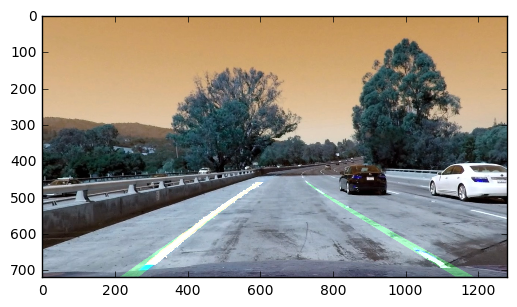

In [83]:
result1 = cv2.addWeighted(undist, 1, unwarp_lane, 0.9, 1)
plt.imshow(result1)

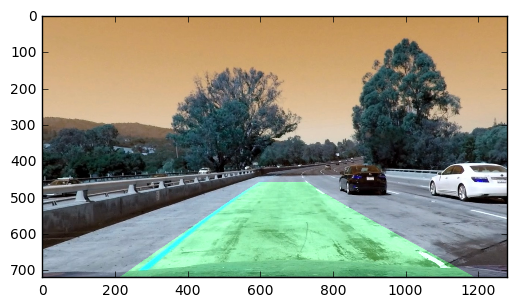

In [84]:
# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([pts]), (0,255, 0))

unwarp_lane2 = cv2.warpPerspective(window_img, Minv, img_size, flags=cv2.INTER_LINEAR)
result = cv2.addWeighted(undist, 1, unwarp_lane2, 0.3, 0)
plt.imshow(result)

In [65]:
def poly_fit(combined, src, dst, mtx, dist, img_size):
    warper, Minv, M = transform(combined)
    #plt.imshow(warper, cmap='gray')
    histogram = np.sum(warper[warper.shape[0]/2:,:], axis=0)
    #plt.plot(histogram)
    out_img = np.dstack((warper, warper, warper))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(warper.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warper.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warper.shape[0] - (window+1)*window_height
        win_y_high = warper.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)


    ploty = np.linspace(0, warper.shape[0]-1, warper.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    nonzero = warper.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 20
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, warper.shape[0]-1, warper.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img = np.dstack((warper, warper, warper))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))

    lane_line = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    #Minv = cv2.getPerspectiveTransform(dst, src)
    unwarp_lane = cv2.warpPerspective(lane_line, Minv, img_size, flags=cv2.INTER_LINEAR)
    result1 = cv2.addWeighted(img, 1, unwarp_lane, 0.9, 1)
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([pts]), (0,255, 0))

    unwarp_lane2 = cv2.warpPerspective(window_img, Minv, img_size, flags=cv2.INTER_LINEAR)
    result = cv2.addWeighted(undist, 1, unwarp_lane2, 0.3, 0)
    return result


In [66]:
def pipe_line(image):
    imshape = image.shape
    img_size = (image.shape[1], image.shape[0])
    undist = undist_f(image)
    gray = gray_f(undist)
    gauss_blur = gaussian_blur(gray, 3)
    hsv = hsv_select(undist, thresh=(100, 255))
    hls_binary = hls_select(image, thresh=(90,255))
    reg_int = region_of_interest(gauss_blur, vertices)
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(30, 150))
    gradx = region_of_interest(gradx, vertices)
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(140, 255))
    grady = region_of_interest(grady, vertices)
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, thresh=(30, 120))
    mag_binary = region_of_interest(mag_binary, vertices)
    dir_binary = dir_thresh(gray, sobel_kernel=ksize, thresh=(0.7, 1.8))
    dir_binary = region_of_interest(dir_binary, vertices)
    combined = np.zeros_like(hls_binary)
    combined[((gradx == 1) & (grady == 1) | (mag_binary == 1) & (dir_binary == 1) | (hls_binary == 1))] = 1
    #plt.figure(figsize=(3, 3))
    plt.imshow(combined, cmap = 'gray')
    #plt.imshow(hls_binary, cmap ='gray')
    output_image = poly_fit(combined, src, dst, mtx, dist, img_size)

    plt.imshow(output_image)

In [67]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [78]:
img = images[1]

error: ..\..\..\modules\core\src\arithm.cpp:639: error: (-209) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function cv::arithm_op


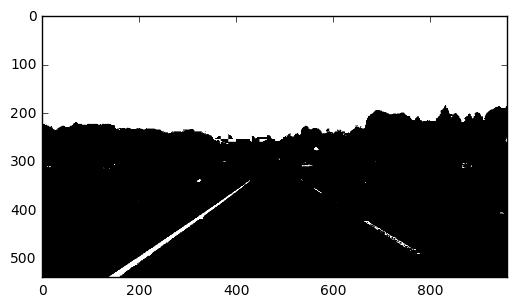

In [79]:
out_img = pipe_line(img)

AttributeError: 'NoneType' object has no attribute 'shape'

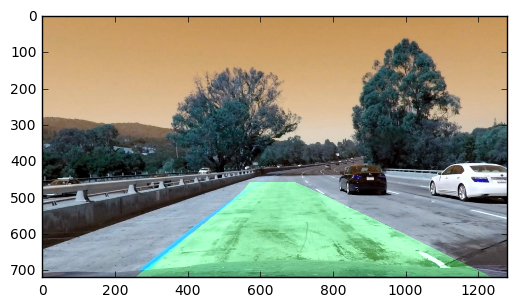

In [69]:
project_video_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(pipe_line) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_video_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_clip))